# This notebook is used for evaluating the stability of a specific docked pose. Please provide two files in amber formats, i): *.crd, or *.rst7; ii) *.prmtop, or *.prm7



In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

In [1]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
import sys
import tarfile
import os
import subprocess
import sys
commands = [
    "rm -rf /usr/local/conda-meta/pinned",
    "mamba install openmm=7.7.0 -y",
    "mamba install -c conda-forge mdanalysis -y",
    "mamba install -c conda-forge parmed -y",
    "conda install -c conda-forge mdtraj -y",
]

for cmd in commands:
    subprocess.run(cmd, shell=True)




In [3]:
#@title load dependencies
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
import parmed as pmd
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import urllib.request
import MDAnalysis as mda
import platform
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from matplotlib import colors
from IPython.display import set_matplotlib_formats

## Go to google drive and download OpenBPMD github repo

In [ ]:
%cd /content/drive/MyDrive/

In [ ]:
!git clone https://github.com/Gervasiolab/OpenBPMD.git

In [ ]:
%cd OpenBPMD

## Upload the two Amber MD inputs,

- Gromacs format also supported
- Change the ligand name to make sure it mathces in the topology file (*.prmtop or *.prm7 for amber, and *.top for groumacs)

Here, the Ligand name in the topology is LIG, it maybe different in your case, please change it.

## Start the Open BPMD simulation

In [ ]:
!python openbpmd.py -s SYS_gaff2.crd -p SYS_gaff2.prmtop -o ligand0_pose0 -lig_resname LIG -nreps 2

## Analysing BPMD simulations

In this notebook, we'll walk through a simple example of how to open and plot the time-wise BPMD scores, take their averages over multiple replicas and determining the final stability score for the given pose.

First, we import a few modules.

In [17]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's start by looking at one replica.

In [18]:
f = os.path.join('/content/drive/MyDrive/chapter3_nightly_built/20240411/OpenBPMD/ligand0_pose0','rep_0','bpm_results.csv')
df = pd.read_csv(f)
df

,CompScore,PoseScore,ContactScore
0,-3.596080,1.403920,1.00
1,-3.595138,1.404862,1.00
2,-0.327293,1.472707,0.36
3,-3.190638,1.809362,1.00
4,-3.526232,1.473768,1.00
...,...,...,...
94,2.744986,4.544986,0.36
95,3.258183,5.058183,0.36
96,0.158444,3.758444,0.72
97,3.441191,5.241191,0.36


As you can see the different scores were calculated for each frame. Let's plot each of the scores for this replica.

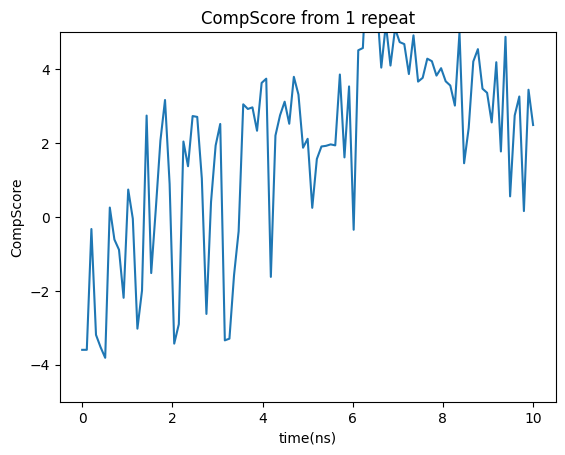

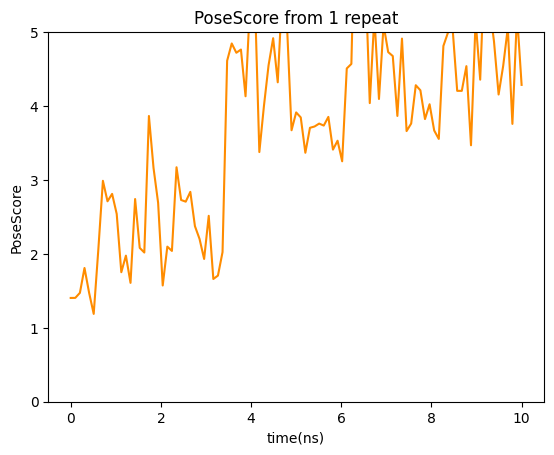

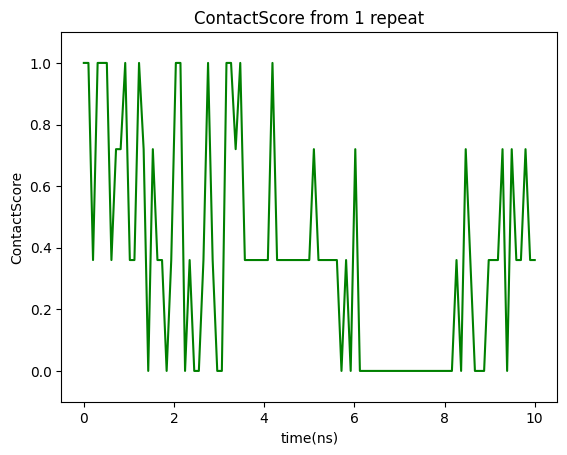

In [19]:
time_sequence = np.linspace(0,10,99)

plt.title('CompScore from 1 repeat')
plt.plot(time_sequence,df['CompScore'])
plt.xlabel('time(ns)')
plt.ylabel('CompScore')
plt.ylim(-5,5)
plt.show()

plt.title('PoseScore from 1 repeat')
plt.plot(time_sequence,df['PoseScore'],color='darkorange')
plt.xlabel('time(ns)')
plt.ylabel('PoseScore')
plt.ylim(0,5)
plt.show()

plt.title('ContactScore from 1 repeat')
plt.plot(time_sequence,df['ContactScore'],color='green')
plt.xlabel('time(ns)')
plt.ylabel('ContactScore')
plt.ylim(-0.1,1.1)
plt.show()

As you can see, the scores are very noisy. This is typical of short metadynamics simulations that haven't yet converged the free energy surface. However, we're not interested in the free energy. We're only want to test the stability of the ligand in the binding pose.

To have more confidence in the stability scores, we run multiple repeat simulations. In reporting the final PoseScore and ContactScore, after 10 repeats, we take the mean of the score over the last 2 ns, which also helps with the noise.

Let's see what the mean of the scores looks when average-out over time.

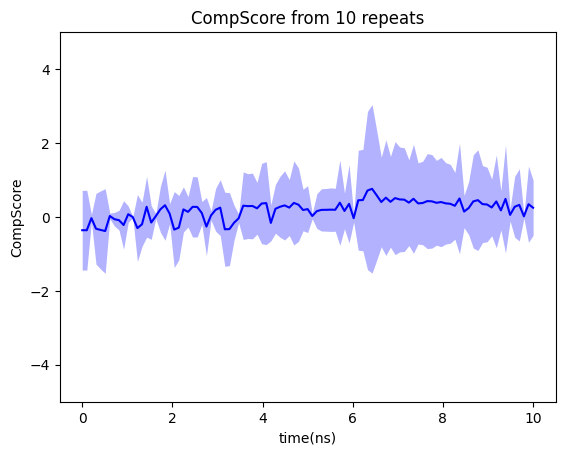

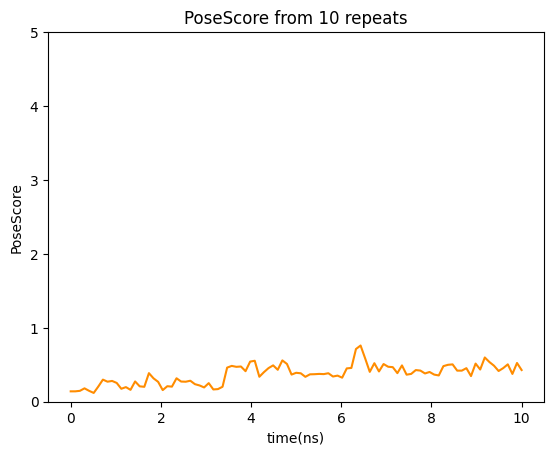

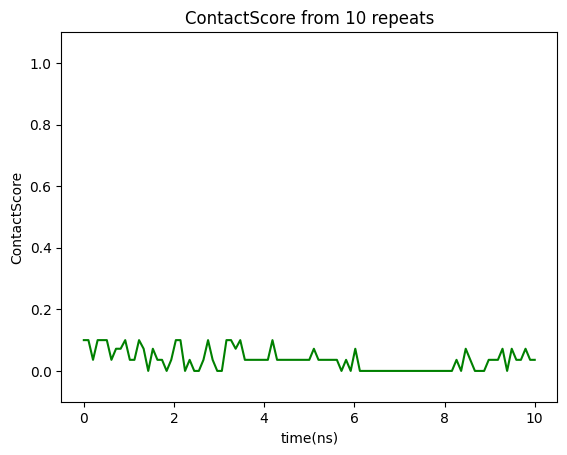

In [22]:
# We'll store the results from 10 repeats in a 10x99 matrix.
CompScores = np.zeros((10,99))
PoseScores = np.zeros((10,99))
ContactScores = np.zeros((10,99))

# Fill those matrices with the scores from each repeat
for idx in range(0,1):
    f = os.path.join('/content/drive/MyDrive/chapter3_nightly_built/20240411/OpenBPMD/ligand0_pose0',f'rep_{idx}','bpm_results.csv')
    df = pd.read_csv(f)
    CompScores[idx] = df['CompScore']
    PoseScores[idx] = df['PoseScore']
    ContactScores[idx] = df['ContactScore']

# Average out the scores from all of the repeats,
# giving a mean of the scores at each frame of the trajectory
averagedCompScore = np.array([ np.mean(CompScores[:,i]) for i in range(0,99) ])
averagedPoseScore = [ np.mean(PoseScores[:,i]) for i in range(0,99) ]
averagedContactScore = [ np.mean(ContactScores[:,i]) for i in range(0,99) ]
# Get the standard deviation for the CompScore
CompScore_stddev = np.array([ np.std(CompScores[:,i]) for i in range(0,99) ])
# An array of time steps for plotting the x axis
time_sequence = np.linspace(0,10,99)

plt.title('CompScore from 10 repeats')
plt.plot(time_sequence,averagedCompScore, color='blue')
# Visualise the standard deviation of CompScore at each frame
plt.fill_between(time_sequence, averagedCompScore-CompScore_stddev, averagedCompScore+CompScore_stddev,
                 color='blue', alpha=0.3, lw=0)
plt.xlabel('time(ns)')
plt.ylabel('CompScore')
plt.ylim(-5,5)
plt.show()

plt.title('PoseScore from 10 repeats')
time_sequence = np.linspace(0,10,99)
plt.plot(time_sequence,averagedPoseScore,color='darkorange')
plt.xlabel('time(ns)')
plt.ylabel('PoseScore')
plt.ylim(0,5)
plt.show()

plt.title('ContactScore from 10 repeats')
time_sequence = np.linspace(0,10,99)
plt.plot(time_sequence,averagedContactScore,color='green')
plt.xlabel('time(ns)')
plt.ylabel('ContactScore')
plt.ylim(-0.1,1.1)
plt.show()

Much better. You can now see how averaging multiple repeats reduces the noise of the scores.

## Take only last 2ns
In the case of a large stability screen, we want to automate things. In order to get a single number that evaluates a given pose/ligand, we take the scores of the final 2 ns.

In [23]:
compList = []
contactList = []
poseList = []
# Find how many repeats have been run
glob_str = os.path.join('/content/drive/MyDrive/chapter3_nightly_built/20240411/OpenBPMD/ligand0_pose0','rep_*')
nreps = len(glob.glob(glob_str))
for idx in range(0, nreps):
    f = os.path.join('/content/drive/MyDrive/chapter3_nightly_built/20240411/OpenBPMD/ligand0_pose0',f'rep_{idx}','bpm_results.csv')
    df = pd.read_csv(f)
    # Since we only want last 2 ns, get the index of
    # the last 20% of the data points
    last_2ns_idx = round(len(df['CompScore'].values)/5)  # round up
    compList.append(df['CompScore'].values[-last_2ns_idx:])
    contactList.append(df['ContactScore'].values[-last_2ns_idx:])
    poseList.append(df['PoseScore'].values[-last_2ns_idx:])

# Get the means of the last 2 ns
meanCompScore = np.mean(compList)
meanPoseScore = np.mean(poseList)
meanContact = np.mean(contactList)
# Get the standard deviation of the final 2 ns
meanCompScore_std = np.std(compList)
meanPoseScore_std = np.std(poseList)
meanContact_std = np.std(contactList)
# Format it the Pandas way
d = {'CompScore': [meanCompScore], 'CompScoreSD': [meanCompScore_std],
     'PoseScore': [meanPoseScore], 'PoseScoreSD': [meanPoseScore_std],
     'ContactScore': [meanContact], 'ContactScoreSD': [meanContact_std]}

results_df = pd.DataFrame(data=d)
results_df = results_df.round(3)

results_df

,CompScore,CompScoreSD,PoseScore,PoseScoreSD,ContactScore,ContactScoreSD
0,11.453,8.512,12.218,7.717,0.153,0.24


The snippet of code above is taken directly from the ```collect_results()``` function in the ```openbpmd.py``` script and you should see the ```results.csv``` file in the ```output``` directory.

A few words of advice on making sense of BPMD results:
1. The lower (more negative) the CompScore, the more likely a given pose to be the correct pose. 'Correct' here means a binding pose that is similar to a pose observed in an experimentally determined structure.
2. PoseScore, being a more objective measure than ContactScore, should be given a slighlty higher weight when the CompScores of two poses are very similar.
3. The standard deviations of the scores might seem really high when compared to the scores themselves. Short metadynamics simulations are known to be very noisy and this is expected. In my experience, poses with lower SD also tend to be have a lower RMSD to the known pose. Therefore, SD is a useful indicator of confidence.
4. CompScores should only be compared between poses of the same ligand, not for comparing stability of different ligands. The correlation between the CompScore of single pose of a ligand and its potency as has not been investigated.